# Hierarchical Clustering

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def plot_parallel_coordinates_clusters(df, cluster_centers):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(cluster_centers)):
        plt.plot(cluster_centers[i], marker='o', label='Cluster %s' % i)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(range(0, len(df.columns)), df.columns, fontsize=18)
    plt.legend(fontsize=10)
    plt.show()

In [ ]:
def plot_radar_clusters(df, cluster_centers):
    # number of variable
    N = len(df.columns)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    for i in range(0, len(cluster_centers)):
        angles = [n / float(N) * 2 * pi for n in range(N)]
        values = cluster_centers[i].tolist()
        values += values[:1]
        angles += angles[:1]
        # Initialise the spider plot
        ax = plt.subplot(polar=True)
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], df.columns, color='grey', size=8) 
        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid')
        # Fill area
        ax.fill(angles, values, 'b', alpha=0.1)

In [ ]:
def plot_date_feature_clusters(df, labels, num_cluster):

    for i in range(num_cluster):
        i_samples = labels==i
        df_cat[i_samples].name.groupby(pd.to_datetime(df_cat.loc[i_samples, 'created_at'], format='%Y-%m-%d %H:%M:%S', errors='raise').dt.year).count().plot(kind="bar")
        plt.show()

In [ ]:
def categorical_hist_clusters(df, labels, feature_name):
    bot_xt_pct = pd.crosstab(labels, df[feature_name])
    bot_xt_pct.plot(kind='bar', stacked=False, 
                       title=f'{feature_name} per cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature_name)
    plt.show()

In [ ]:
def plot_numerical_features_clusters(df, labels, num_cluster):
    """
    print and plot distribution of numerical features conditioned by the cluster
    """
    
    for i in range(num_cluster):
        i_samples = labels==i
        df[i_samples].boxplot()
        df[i_samples].hist()
        plt.show()

In [ ]:
def scatter_features_clusters(df, labels):
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            feature_1 = df.columns[i]
            feature_2 = df.columns[j]
            
            print(f"{feature_1} - {feature_2}")
            plt.scatter(df[feature_1], df[feature_2], c=labels, s=20)
            plt.tick_params(axis='both', which='major', labelsize=22)
            plt.show()

In [33]:
df = pd.read_csv("user_profiles.csv", skipinitialspace=True, sep=',')

In [34]:
df.head()

,Unnamed: 0,name,lang,bot,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,reply_count_entropy,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,62.340909,14.015152,0.0,0.272727,0.0,0.0,0.0,0.0,0.037879,0.190903,1.609438,0.037879,0.190903,1.609438
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,4,69.082645,15.041322,0.0,0.338843,0.0,0.0,0.0,0.0,0.049587,0.217090,1.791759,0.024793,0.155495,1.098612
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,7,19.250000,5.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,86.944871,18.689463,0.0,0.004885,0.0,0.0,0.0,0.0,0.130495,0.336848,5.231109,0.150035,1.326298,3.554720
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,8,72.311246,14.582073,0.0,0.448996,0.0,0.0,0.0,0.0,0.053341,0.224712,5.267858,0.016772,0.142619,3.965939


In [35]:
cat_feature = df[['name','lang','created_at', 'bot']]
del df['name']
del df['lang']
del df['created_at']
del df['bot']
df.head()

,Unnamed: 0,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,reply_count_entropy,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
0,2353593986,76,62.340909,14.015152,0.0,0.272727,0.0,0.0,0.0,0.0,0.037879,0.190903,1.609438,0.037879,0.190903,1.609438
1,2358850842,4,69.082645,15.041322,0.0,0.338843,0.0,0.0,0.0,0.0,0.049587,0.217090,1.791759,0.024793,0.155495,1.098612
2,137959629,7,19.250000,5.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,466124818,50,86.944871,18.689463,0.0,0.004885,0.0,0.0,0.0,0.0,0.130495,0.336848,5.231109,0.150035,1.326298,3.554720
4,2571493866,8,72.311246,14.582073,0.0,0.448996,0.0,0.0,0.0,0.0,0.053341,0.224712,5.267858,0.016772,0.142619,3.965939


In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [37]:
scaler = StandardScaler()
scaler.fit(df.values)

StandardScaler()

In [38]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df.values)

In [39]:
X[:5]

array([[0.74359032, 0.26116838, 0.24521037, 0.09406142, 0.        ,
        0.27272727, 0.        , 0.        , 0.        , 0.        ,
        0.03787879, 0.38180616, 0.1960894 , 0.00189394, 0.01909031,
        0.19655198],
       [0.74525164, 0.0137457 , 0.27306878, 0.10094847, 0.        ,
        0.33884298, 0.        , 0.        , 0.        , 0.        ,
        0.04958678, 0.43417936, 0.21830294, 0.00123967, 0.01554949,
        0.1341676 ],
       [0.043385  , 0.02405498, 0.06714876, 0.0352349 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.14709481, 0.17182131, 0.34687963, 0.12543264, 0.        ,
        0.00488486, 0.        , 0.        , 0.        , 0.        ,
        0.13049546, 0.67369547, 0.63734358, 0.00750174, 0.13262981,
        0.43411874],
       [0.81245306, 0.02749141, 0.28641011, 0.09786626, 0.        ,
        0.44899643, 0.        , 

In [40]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

##### Cosine similarity

In [ ]:
data_dist = pdist(X, metric='cosine') #computes the similarity matrix using cosine similarity
data_link = linkage(data_dist, method='average', metric='cosine') #performs hierarchical clustering
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
#res = dendrogram(data_link, p=5, color_threshold=1.0, truncate_mode='level')

In [ ]:
data_dist = pdist(X, metric='cosine') #computes the similarity matrix using cosine similarity
data_link = linkage(data_dist, method='single', metric='cosine') #performs hierarchical clustering
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

In [ ]:
data_dist = pdist(X, metric='cosine') #computes the similarity matrix using cosine similarity
data_link = linkage(data_dist, method='complete', metric='cosine') #performs hierarchical clustering
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### Euclidean distance

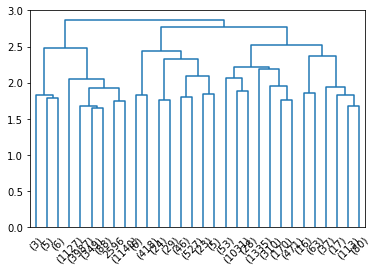

In [45]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

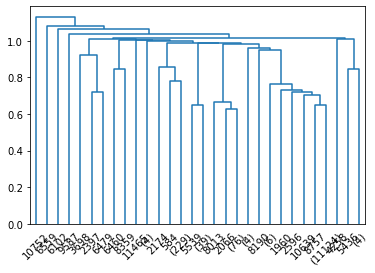

In [43]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

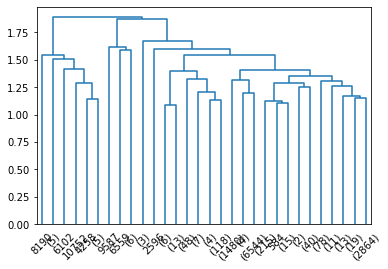

In [20]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

In [21]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

array([3, 3, 1, ..., 1, 3, 2], dtype=int64)

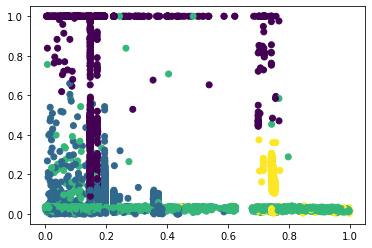

In [22]:
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

### Plot Cluster Results

# dbscan

In [133]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [146]:
dbscan = DBSCAN(eps=1.3, min_samples=50)
dbscan.fit(X)

DBSCAN(eps=1.3, min_samples=50)

In [147]:
dbscan.labels_[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [148]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([1902, 9208,  398], dtype=int64))

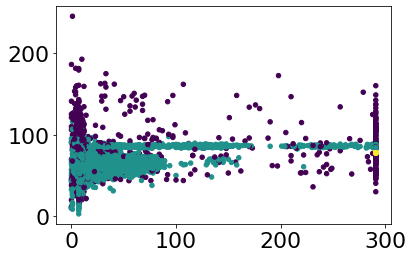

In [149]:
plt.scatter(df['statuses_count'], df['avg_length'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [150]:
print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.2746681129814607


In [139]:
from scipy.spatial.distance import pdist, squareform

In [140]:
dist = pdist(X, 'euclidean') #pair wise distance
print (dist)
dist = squareform(dist) #distance matrix given the vector dist
print()
print(dist)

[1.12726201 3.50932495 2.53740528 ... 4.27686627 6.40269121 4.08993571]

[[0.         1.12726201 3.50932495 ... 4.17398053 0.69506543 4.35279435]
 [1.12726201 0.         3.80474226 ... 4.1203726  0.72708444 4.4055429 ]
 [3.50932495 3.80474226 0.         ... 5.47077606 3.56751143 5.70515257]
 ...
 [4.17398053 4.1203726  5.47077606 ... 0.         4.27686627 6.40269121]
 [0.69506543 0.72708444 3.56751143 ... 4.27686627 0.         4.08993571]
 [4.35279435 4.4055429  5.70515257 ... 6.40269121 4.08993571 0.        ]]


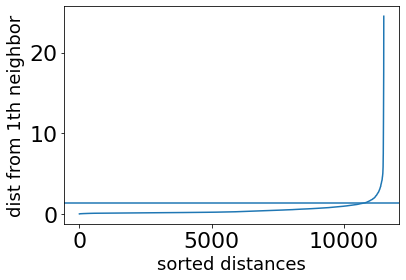

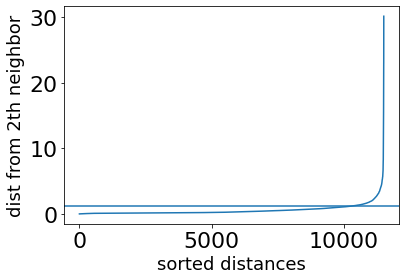

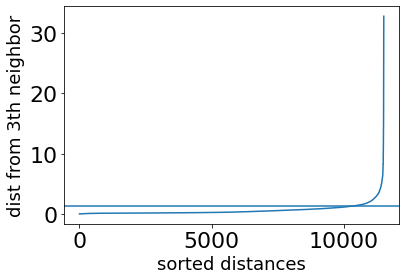

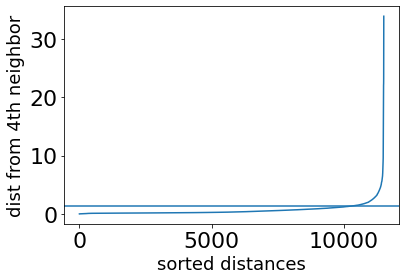

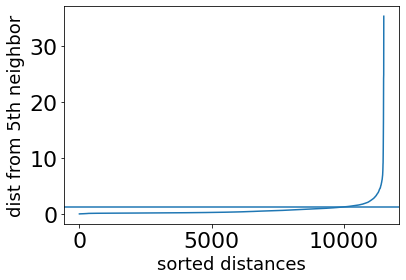

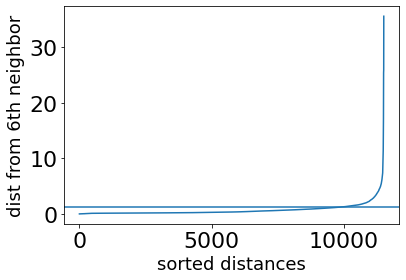

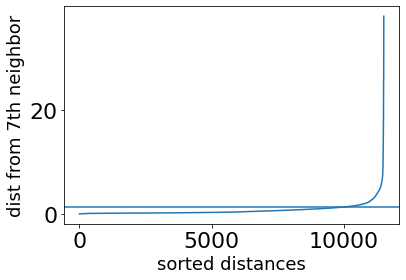

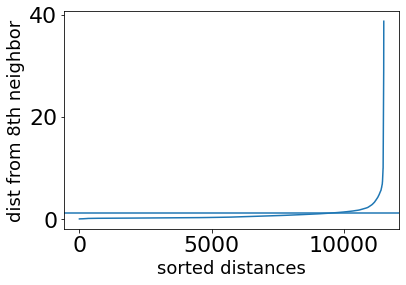

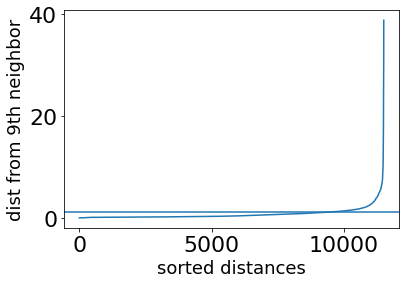

In [141]:
for k in range (1, 10):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.axhline(y=1.3)
    plt.show()

### Plot Cluster Results